In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
import sys
import paths
sys.path.append(paths.scripts_root)
import util

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
#fnames = ['/home/trafferty/tmp_noback/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_01.csv',
#           '/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_02.csv',
#           '/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_03.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_WS_2017_06_29_IP8.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_WS_2017_06_29_IP8_from_MISC.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_02_StatusDO-to-MISC.csv']
fnames = ['/home/trafferty/tmp/TTM_Vibration/Wireshark_Data_2017_07_07/IMCS_traffic_2017_07_07_52-imprints.csv']
ttm_ws_data = []
for fname in fnames:
    with open(fname, 'r') as csv_file:
        ttm_ws = csv_file.readlines()
        ttm_ws_data.append(ttm_ws)
        print("Read in %d lines from %s" %(len(ttm_ws), os.path.basename(fname)))
        
from os.path import expanduser

tmp_dir = '%s/tmp' % (expanduser("~"))
ws_dir = '%s/workspace' % (expanduser("~"))

IMCS_mode = True
TTM_Merge = True

if IMCS_mode:
    TTM_Merge = False

Read in 1461131 lines from IMCS_traffic_2017_07_07_52-imprints.csv


In [5]:
def parse_into_data_sets(data):
    data_ranges = []
    data_sets = []
    data_gaps = []
    max_delta = 2
    start = 0
    cnt = 0
    found_first = False

    for idx, d in enumerate(data):
        if len(d) <= 1:
            print("Found blank line: ", d)
            continue

        if found_first == False:
            found_first = True
            ts_prev = float(d.split(",")[1][1:-1])
#             cum = 0.0
#             data_ts = []
        else:
            ts = float(d.split(",")[1][1:-1])
            delta = ts - ts_prev
            if delta > max_delta:
                data_gaps.append(delta)
                
                end = idx - 1

                data_sets.append( [ data[start:end] ] )
                data_ranges.append([start, end])
                cnt += 1                
                ts1 = float(data[start].split(",")[1][1:-1])
                ts2 = float(data[end].split(",")[1][1:-1])
                id1 = float(data[start].split(",")[0][1:-1])
                id2 = float(data[end].split(",")[0][1:-1])
                print("Data set %d, range: %d - %d (WS IDs: %d - %d) (total: %d) elapsed time: %f" % (cnt, start,end, id1, id2, (end-start), (ts2-ts1)))

#                 cum = 0.0
#                 data_ts = []
                start = idx
#             else:
#                 cum += delta
#                 data_ts.append(cum)
            ts_prev = ts

    end = idx
    data_sets.append( [ data[start:end] ] )
    data_ranges.append([start, end])
    cnt += 1
    ts1 = float(data[start].split(",")[1][1:-1])
    ts2 = float(data[end].split(",")[1][1:-1])
    id1 = float(data[start].split(",")[0][1:-1])
    id2 = float(data[end].split(",")[0][1:-1])
    print("Data set %d, range: %d - %d (WS IDs: %d - %d) (total: %d) elapsed time: %f" % (cnt, start,end, id1, id2, (end-start), (ts2-ts1)))
        
    print(data_gaps)
    return data_ranges, data_sets, data_gaps



In [6]:
def parse_into_single_data_set(data):
    data_ranges = []
    data_sets = []
    start = 1
    end = len(data) - 1
    data_sets.append( [ data[start:end] ] )
    #data_ranges.append(data[start:idx])
    len(data_ranges)
        
    return data_ranges, data_sets, []


In [7]:
'''
    data_set[0] = list, n=len(data_set), raw data from csv: "105","1366.450402000","192.168.2.11","192.168.2.1","TCP","118","49203 > 5259 [PSH, ACK] Seq=321 Ack=1 Win=256 Len=64"
    data_set[1] = list, n=num of packets with data, deltas between data packets
    data_set[1] = list, n=num of packets with data, time stamps
    data_set[2] = list, n=num of packets with data, data lengths in packets
'''
 
for ttm_ws in ttm_ws_data:
    if IMCS_mode:
        print("IMCS mode indicated; parsing into single dataset")
        data_ranges, data_sets, data_gaps = parse_into_single_data_set(ttm_ws[1:])
    else:
        print("Parsing into datasets...")
        data_ranges, data_sets, data_gaps = parse_into_data_sets(ttm_ws[1:])
    
    print("Data set cnt:", len(data_sets))
    print("------------------------------------------------")
    
    for ds_num, data_set in enumerate(data_sets):
        delay_set = []
        packet_len_lst = []
        for idx, line in enumerate(data_set[0]):
            if idx == 0:
                ts_prev = float(line.split(",")[1][1:-1])
                cum = 0.0
                data_ts = []
                large_delay_ids = []
            else:
                idx = line.find("Len=")
                if idx >= 0:
                    packet_len = int(line[idx:-2].split("=")[1])
                    packet_len_lst.append(packet_len)
                    
                    ts = float(line.split(",")[1][1:-1])
                    delta = ts - ts_prev
                    delay_set.append(delta)
                    ts_prev = ts

                    cum += delta
                    data_ts.append(cum)
                    
                    thresh = 0.015
                    if delta > thresh:
                        _id = line.split(",")[0][1:-1]
                        _ts = line.split(",")[1][1:-1]
                        large_delay_ids.append( (_id, cum, delta))
                        print("[%d][%s, %s] Delta = %f (> thresh:%f)" % (ds_num, _id, _ts, delta, thresh))
                    
                #else:
                    #print("Found non-data msg: ", line[:-1])

        data_set.append(data_ts)
        data_set.append(delay_set)
        data_set.append(packet_len_lst)
        data_set.append(large_delay_ids)
        if ds_num == 0:
            data_set.append(0)
            print("data set 0, no gap")
        else:
            data_set.append(data_gaps[ds_num-1])
            print("data set %d, gap: %f" % (ds_num, data_gaps[ds_num-1]))
        

IMCS mode indicated; parsing into single dataset
Data set cnt: 1
------------------------------------------------
[0][531080, 237.959725000] Delta = 0.020526 (> thresh:0.015000)
[0][642771, 285.753544000] Delta = 0.020594 (> thresh:0.015000)
[0][677087, 301.891999000] Delta = 0.020206 (> thresh:0.015000)
[0][677649, 302.188849000] Delta = 0.020207 (> thresh:0.015000)
[0][785095, 348.234193000] Delta = 0.043013 (> thresh:0.015000)
[0][1297765, 567.383357000] Delta = 0.017628 (> thresh:0.015000)
[0][1475876, 642.904144000] Delta = 0.053977 (> thresh:0.015000)
[0][1522173, 663.409495000] Delta = 0.053445 (> thresh:0.015000)
[0][1884706, 823.582024000] Delta = 0.018614 (> thresh:0.015000)
[0][1943902, 848.597390000] Delta = 0.020689 (> thresh:0.015000)
[0][2044801, 892.707107000] Delta = 0.021009 (> thresh:0.015000)
[0][2204214, 961.471261000] Delta = 0.019725 (> thresh:0.015000)
[0][2257903, 984.680183000] Delta = 0.017958 (> thresh:0.015000)
[0][2381097, 1036.738504000] Delta = 0.025455 

In [223]:
for idx, data_set in enumerate(data_sets):
    print("--------------------------------------------------")
    print("data_set[%d]:" % idx)
    raw =data_set[0]
    ts = data_set[1]
    deltas = data_set[2]
    packet_len = data_set[3]
    large_delay_ids = data_set[4]
    gap  = data_set[5]

    print("  Number of raw lines in data_set :", len(raw))
    print("  Number of delta pts             :", len(deltas))
    print("  Number of time stamps           :", len(ts))
    print("  Number of lines with packet data:", len(packet_len))
    print("  Data set gap                    :", gap)
    print("  first 5 TSs: %s" % (', '.join(str(e) for e in ts[0:5])) )
    print("  last  5 TSs: %s" % (', '.join(str(e) for e in ts[-5:])) )
    if len(large_delay_ids) > 0:
        print("  Delays occured at: ")
        for large_delay_id in large_delay_ids:
            print("   Wireshark id: %s, ts: %.3f, delay: %f" % (large_delay_id[0], float(large_delay_id[1]), large_delay_id[2]))

--------------------------------------------------
data_set[0]:
  Number of raw lines in data_set : 3994
  Number of delta pts             : 3982
  Number of time stamps           : 3982
  Number of lines with packet data: 3982
  Data set gap                    : 0
  first 5 TSs: 0.002350999999976011, 0.004886999999996533, 0.006314999999972315, 0.008172000000001844, 0.01029199999999264
  last  5 TSs: 10.35812599999997, 10.360815000000002, 10.363423000000012, 10.365994999999998, 10.369092999999964
--------------------------------------------------
data_set[1]:
  Number of raw lines in data_set : 3998
  Number of delta pts             : 3993
  Number of time stamps           : 3993
  Number of lines with packet data: 3993
  Data set gap                    : 13.161530000000027
  first 5 TSs: 0.0036020000000007713, 0.006030999999950382, 0.007837999999992462, 0.009497999999950935, 0.011612999999954354
  last  5 TSs: 10.379183999999952, 10.381799, 10.384326999999985, 10.387009999999975, 10.3

In [160]:
if TTM_Merge:
    print("Merging datasets...")
    merged_data_set = []
    merged_data_set.append( [ [], [], [], [] ])
    for data_set in data_sets:        
        for idx, d in enumerate(data_set[1]):
            merged_data_set[0][0].append(data_set[0][idx])
            merged_data_set[0][1].append(data_set[1][idx])
            merged_data_set[0][2].append(data_set[2][idx])
            merged_data_set[0][3].append(data_set[3][idx])
            
len(merged_data_set[0][0])

Merging datasets...


102972

Merging datasets...
Creating PDF (/home/trafferty/tmp/TTM_WS_2017_07_07_7-52-fields.pdf) with 1 pages.
Total plots: 1, plots per page: 1
 plot 0, data pts: 206467, 206467
Saving pdf...


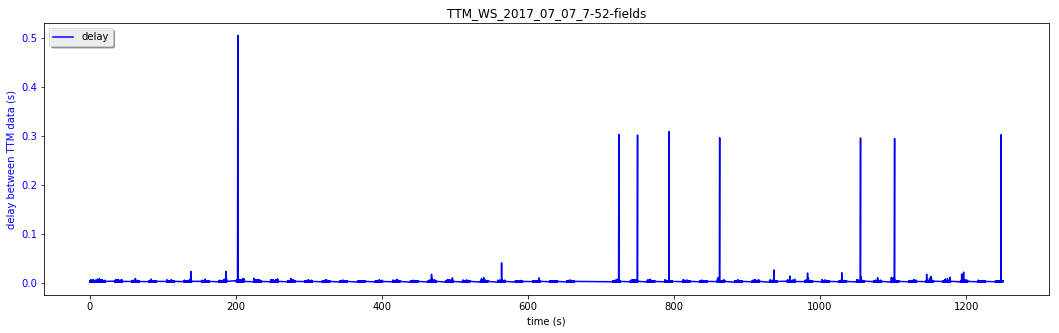

In [224]:
save_pdf = True

if TTM_Merge:
    print("Merging datasets...")
    merged_data_set = []
    merged_data_set.append( [ [], [], [], [] ])
    cum = 0.0
    for data_set in data_sets:        
        for idx, d in enumerate(data_set[1]):
            cum += data_set[2][idx]
            merged_data_set[0][0].append(data_set[0][idx])
            merged_data_set[0][1].append(cum)
            merged_data_set[0][2].append(data_set[2][idx])
            merged_data_set[0][3].append(data_set[3][idx])
        cum += data_set[5]
            
    data_sets_to_plot = merged_data_set
else:
    data_sets_to_plot = data_sets

num_plots = len(data_sets_to_plot)

if save_pdf:
    plot_file_pdf = "%s/%s.pdf" % (tmp_dir, os.path.basename(fnames[0][0:-4]))
    from matplotlib.backends.backend_pdf import PdfPages
    import datetime
    pdf = PdfPages(plot_file_pdf)
    # set the file's metadata via the PdfPages object:
    d = pdf.infodict() 
    d['Title'] = os.path.basename(fnames[0][0:-4])
    d['Author'] = 'Tom Rafferty'
    d['Subject'] = 'TTM IP8 Interface Analysis'
    d['CreationDate'] = datetime.datetime.today()
    d['ModDate'] = datetime.datetime.today()

    # setup vars to control page layout
    plots_per_page = num_plots
    num_pages = np.ceil(num_plots / plots_per_page)
    nb_pages = int(np.ceil(num_plots / float(plots_per_page)))
    grid_size = (plots_per_page, 1)

    print("Creating PDF (%s) with %d pages." % (plot_file_pdf, num_pages))
    print("Total plots: %d, plots per page: %d" % (num_plots, plots_per_page))

    fig, axes = plt.subplots(nrows=num_plots, ncols=1, squeeze=True, figsize=(18,(5*num_plots)))

for idx, data_set in enumerate(data_sets_to_plot):
    if len(data_set[0]) ==0:
        continue
        
    print( " plot %d, data pts: %d, %d" % (idx, len(data_set[1]),len(data_set[2])))
    if num_plots > 1:
        ax1 = axes[idx]
    else:
        ax1 = axes

    ax1.plot(data_set[1], data_set[2], color='b', label='delay')
    ax1.set_xlabel('time (s)')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('delay between TTM data (s)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_title(os.path.basename(fnames[0][0:-4]))
    leg1 = ax1.legend(loc='upper left', shadow=True)

#     ax2 = ax1.twinx()
#     ax2.plot(data_set[1], data_set[3],  color='c', label='packet size')
#     ax2.set_ylabel('packet size', color='m')
#     ax2.tick_params('y', colors='m')
#     leg2 = ax2.legend(loc='upper right', shadow=True)
    
fig.savefig("%s/%s.png" % (tmp_dir, os.path.basename(fnames[0][0:-4])))

if save_pdf:
#         for fig in figs:
#             fig.savefig(pdf, format='pdf')
    print("Saving pdf...")
    fig.savefig(pdf, format='pdf')
    pdf.close()


In [ ]:
# delay_sets = []
# for ttm_ws in ttm_ws_data:
#     delay_set = []
#     for idx, line in enumerate(ttm_ws[1:]):
#         if idx == 0:
#             ts_prev = float(line.split(",")[1][1:-1])
#         else:
#             ts = float(line.split(",")[1][1:-1])
#             delay_set.append(ts - ts_prev)
#             ts_prev = ts
#     delay_sets.append(delay_set)
    
# print("Delay set cnt:", len(delay_sets))